# Preprocessing pipeline [dev]

The goal of this pipeline is to produce preprocessed data that is clean enough to be further analyzed in ERP or connectivity analyses. This pipeline is semi-automatic; manual steps are not necessarily required but it is advised to revisit the cleaned epochs. ICA components have to be selected manually.

## Steps
Considering the remarks [here](https://autoreject.github.io/faq.html#should-i-apply-ica-first-or-autoreject-first)


- bandpass filter 0.1-45Hz
- create fixed length epochs
- mark and reject bad data segments with [autoreject](https://www.sciencedirect.com/science/article/abs/pii/S1053811917305013)
- fit ICA on cleaned data segments
- process components
- apply ICA
- run autoreject with more strict thresholds


## Install package requirements

Can be ignored if requirements are already installed.

In [ ]:
!pip install -r ../requirements.txt

## Import packages


```%matplotlib qt``` is for interactive visualization (can be slower); 
switch to ```%matplotlib inline``` for (faster) static plots

In [1]:
import os
from pathlib import Path
from ipyfilechooser import FileChooser

import mne
import pandas as pd
import numpy as np 
import autoreject
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
%matplotlib qt

## Load raw data

In [2]:
# Set base path to EEG data
base_path = 'D:\TMS_rewiring'

In [3]:
# Create folder for preprocessed and interim files
folder_name = 'preprocessed'
interim_path = os.path.join(base_path, folder_name)

if not os.path.exists(interim_path):
    os.makedirs(interim_path)

In [4]:
# Choose a file using a FileChooser widget
fc = FileChooser(base_path)
fc.filter_pattern = '*.vhdr'

display(fc)

FileChooser(path='D:\TMS_rewiring', filename='', title='HTML(value='', layout=Layout(display='none'))', show_h…

In [ ]:
raw_zs = mne.io.read_raw_eeglab(fc.selected)

In [ ]:
raw_zs.plot(n_channels=32)

In [5]:
# Load selected file
raw_file_path = fc.selected
raw_id = Path(raw_file_path).stem
id_split = raw_id.split('_')
subject = id_split[0]
condition = id_split[1]
num_day = [x for x in id_split[-1] if x.isdigit()][0]

raw = mne.io.read_raw_brainvision(raw_file_path, preload=False, verbose=True)

Extracting parameters from D:\TMS_rewiring\Raw_data\24_L\Day1\EEG\24_L_Day1.vhdr...
Setting channel info structure...


In [ ]:
# Visualize sensor positions
raw.plot_sensors(show_names=True, ch_groups='position')

In [ ]:
# Show PSD
raw.plot_psd()

## Event processing

In [6]:
# Read annotations from raw
events_from_annot, _ = mne.events_from_annotations(raw)

event_dict = {83: f'rs_{num_day}',
              91: f'asrt_{num_day}_1',
              93: f'asrt_{num_day}_2',
              95: f'asrt_{num_day}_3',
              97: f'asrt_{num_day}_4',
              99: f'asrt_{num_day}_5',
              101: f'asrt_{num_day}_6',
              87: f'rs_{int(num_day)+1}'}

events_df = pd.DataFrame(data=events_from_annot, columns=['start_time', 'ignore', 'event_id']).drop(columns=['ignore'])
events_df['start_time'] = events_df['start_time'] / raw.info['sfreq']

events_df.head()

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 17', 'Stimulus/S 18', 'Stimulus/S 19', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 24', 'Stimulus/S 25', 'Stimulus/S 26', 'Stimulus/S 27', 'Stimulus/S 28', 'Stimulus/S 29', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 34', 'Stimulus/S 35', 'Stimulus/S 36', 'Stimulus/S 37', 'Stimulus/S 38', 'Stimulus/S 39', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 43', 'Stimulus/S 44', 'Stimulus/S 45', 'Stimulus/S 46', 'Stimulus/S 47', 'Stimulus/S 48', 'Stimulus/S 49', 'Stimulus/S 51', 'Stimulus/S 52', 'Stimulus/S 61', 'Stimulus/S 62', 'Stimulus/S 63', 'Stimulus/S 64', 'Stimulus/S 65', 'Stimulus/S 66', 'Stimulus/S 67', 'Stimulus/S 68', 'Stimulus/S 69', 'Stimulus/S 70', 'Stimulus/S 71', 'Stimulus/S 72', 'Stimulus/S 75', 'Stimulus/S 77', 'Stimulus/S 78', 

start_time  event_id
0       0.000     99999
1      11.554         5
2      11.778        85
3      21.604        83
4     321.636        84

In [7]:
block_start_times = []
for epoch_start_num in [91,93,95,97,99,101]:
    sub_df = events_df.iloc[np.array(events_df.index[events_df['event_id'] == epoch_start_num]) + 2]
    if all(sub_df['event_id'].isin([19, 119])):
        block_start_times.extend(sub_df['start_time'].values.tolist())
    else:
        print('Something unexpected happened, check the triggers!')


block_events = events_df[events_df['event_id'].isin([91,93,95,97,99,101])]
block_events['event'] = block_events['event_id'].map(event_dict).fillna(block_events['event_id'])
block_events['real_start_time'] = block_start_times
if num_day != '3':
    try:
        # only seq A
        block_events['end_time'] = events_df[events_df['event_id'] == 52]['start_time'].values
        block_events['sequence'] = 'A'
    except IndexError:
        # only seq B
        block_events['end_time'] = events_df[events_df['event_id'] == 152]['start_time'].values
        block_events['sequence'] = 'B'
else:
    #Az utolsó napon az 1-3-5 epochokban van az A és a 2-4-6 epochokban a B szekvencia a páratlan számú részvevőknél, 
    #és a párosoknál forditva.
    if (int(subject) % 2) == 0:
        block_events.loc[block_events['event_id'].isin([91, 95, 99]), 'sequence'] = 'B'
        block_events.loc[block_events['event_id'].isin([93, 97, 101]), 'sequence'] = 'A'
    else:
        block_events.loc[block_events['event_id'].isin([91, 95, 99]), 'sequence'] = 'A'
        block_events.loc[block_events['event_id'].isin([93, 97, 101]), 'sequence'] = 'B'
    
    block_events['end_time'] = events_df[events_df['event_id'].isin([52, 152])]['start_time'].values
    

c:\users\gvadasz\documents\eeg\eeg-preprocessing\venv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
c:\users\gvadasz\documents\eeg\eeg-preprocessing\venv\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
c:\users\gvadasz\documents\eeg\eeg-preprocessing\venv\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be

In [9]:
block_events

start_time  event_id     event  real_start_time  end_time sequence
818     1478.840        91  asrt_1_1         1481.276  1609.886        A
1081    1633.576        91  asrt_1_1         1635.296  1763.906        A
1344    1791.266        91  asrt_1_1         1792.302  1921.230        A
1617    1955.630        91  asrt_1_1         1956.748  2086.160        A
1888    2112.336        91  asrt_1_1         2113.436  2242.014        A
2154    2288.066        93  asrt_1_2         2289.452  2418.012        A
2417    2446.842        93  asrt_1_2         2447.826  2576.586        A
2687    2603.814        93  asrt_1_2         2606.182  2735.060        A
2956    2763.940        93  asrt_1_2         2764.824  2893.384        A
3220    2919.844        93  asrt_1_2         2920.662  3049.524        A
3494    3139.732        95  asrt_1_3         3147.472  3276.016        A
3755    3303.628        95  asrt_1_3         3304.662  3433.356        A
4022    3470.060        95  asrt_1_3         3471.528  3600.272        A
4291    3629.602        95  asrt_1_3         3630.736  3759.330        A
4555    3788.476        95  asrt_1_3         3789.226  3917.770        A
4819    3964.124        97  asrt_1_4         3965.208  4093.736        A
5080    4121.330        97  asrt_1_4         4122.382  4251.042        A
5345    4278.002        97  asrt_1_4         4279.338  4408.048        A
5613    4431.356        97  asrt_1_4         4432.940  4561.818        A
5883    4587.510        97  asrt_1_4         4588.812  4717.490        A
6151    4971.234        99  asrt_1_5         4973.636  5102.264        A
6415    5125.754        99  asrt_1_5         5126.822  5255.416        A
6680    5281.558        99  asrt_1_5         5282.642  5411.504        A
6951    5443.268        99  asrt_1_5         5444.186  5572.748        A
7213    5604.112        99  asrt_1_5         5605.296  5734.074        A

In [8]:
# Create slice from resting events
resting_events = events_df[events_df['event_id'].isin([83, 87])]
resting_end_times = events_df[events_df['event_id'].isin([84, 88])]['start_time'].values

resting_events['end_time'] = resting_end_times

resting_events.reset_index(inplace=True)
resting_events['event'] = resting_events['event_id'].map(event_dict).fillna(resting_events['event_id'])


#block_events['end_time'] = events_df[events_df['event_id'] == 52].rename(columns={'start_time': 'end_time'})['end_time']

#events = block_events.reset_index().append(resting_events)


c:\users\gvadasz\documents\eeg\eeg-preprocessing\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\users\gvadasz\documents\eeg\eeg-preprocessing\venv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Filtering the raw data

### Bandpass filter 0.1 - 45 Hz

In [ ]:
# Bandpass filter 0.1 - 45 Hz
l_freq = 0.1
h_freq = 45
raw_filtered = raw.copy().filter(l_freq=l_freq, h_freq=h_freq)

In [ ]:
# Bandpass filter 1 - 30 Hz
l_freq = 1
h_freq = 30
raw_filtered_ica = raw.copy().filter(l_freq=l_freq, h_freq=h_freq)

## Cut raw data based on triggers


## I. Resting period

### Create folder for preprocessed files

In [10]:
# Create path to interim epoch files
interim_epochs_path = os.path.join(interim_path, condition, 'epochs_rs')
if not os.path.exists(interim_epochs_path):
    os.makedirs(interim_epochs_path)

# Create path to interim raw files
interim_raw_path = os.path.join(interim_path, condition, 'raw_rs')
if not os.path.exists(interim_raw_path):
    os.makedirs(interim_raw_path)

### Crop raw data

#### Merge RS segments 

In [11]:
raws = []
for idx, event in resting_events.iterrows():
    raws.append(raw.copy().crop(tmin=event['start_time'], tmax=event['end_time'], include_tmax=True))
    
raw_rs = mne.concatenate_raws(raws)

# how to recover rs at the end?
# resting_events end time - start time
# test = raw_rs_before.copy().crop(tmin=0.0, tmax=300.032, include_tmax=True)
#test2 = raw_rs_before.copy().crop(tmin=300.033, tmax=300.033+300.064, include_tmax=True)
# drop boundary


In [12]:
# Bandpass filter 1 - 30 Hz
l_freq = 1
h_freq = 30
raw_rs_bandpass_ica = raw_rs.load_data().copy().filter(l_freq=l_freq, h_freq=h_freq)

Reading 0 ... 300033  =      0.000 ...   600.066 secs...
Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (3.302 sec)



In [ ]:
# rs_start_index = resting_events[resting_events['event_id'] == 83]['start_time'].values[0]
# rs_end_index = resting_events[resting_events['event_id'] == 83]['end_time'].values[0]

# period = resting_events[resting_events['event_id'] == 83]['event'].values[0]

# raw_rs_before = raw_filtered.copy().crop(tmin=rs_start_index, tmax=rs_end_index, include_tmax=True)

# fid = f'{subject}_{condition}_{period}'
# raw_rs_before.info['fid'] = fid

### Visualize raw resting segment (optional)

In [ ]:
# interactively scroll through data
period = '_and_'.join(resting_events['event'].values)
fid = f'{subject}_{condition}_{period}'
raw_rs_bandpass_ica.plot(title=fid,
                   n_channels=32,
                   remove_dc=True)

### 1. Create interim epochs 

In [16]:
# create fixed length epoch for preprocessing
EPOCH_LENGTH_IN_SECONDS = 1.0
#OVERLAP = 0.5 * EPOCH_LENGTH_IN_SECONDS

events = mne.make_fixed_length_events(raw_rs_bandpass_ica,
                                  id=1,
                                  first_samp=True,
                                  duration=EPOCH_LENGTH_IN_SECONDS,
                                  overlap=0.0)

epochs = mne.Epochs(raw=raw_rs_bandpass_ica,
                    events=events,
                    picks='eeg',
                    event_id=1,
                    baseline=None,
                    tmin=0.,
                    tmax=EPOCH_LENGTH_IN_SECONDS - 0.002,
                    preload=True)

Not setting metadata
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
Loading data for 600 events and 500 original time points ...
1 bad epochs dropped


### 2. Run ICA

#### 2.1. Find rejection threshold for ICA

"ICA solutions can be affected by high amplitude artifacts, therefore we recommend to determine a reasonable rejection threshold on which data segments to ignore in the ICA. autoreject (global) can be used exactly for this purpose"


In [19]:
# find global rejection threshold for ICA
reject = autoreject.get_rejection_threshold(epochs, decim=2)
print(reject)

Estimating rejection dictionary for eeg
{'eeg': 6.19157550150404e-05}


#### 2.2. Fit ICA on epochs


In [18]:
n_components = 32
method = 'infomax'

ica = mne.preprocessing.ICA(n_components=n_components, random_state=42, method=method)
ica.fit(epochs, reject=reject, tstep=EPOCH_LENGTH_IN_SECONDS)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 32 components
 
Fitting ICA took 143.6s.


<ICA | epochs decomposition, fit (infomax): 299500 samples, 32 components, channels used: "eeg">

#### 2.3. Visualize ICA components on epochs

In [20]:
ica.plot_components()

[<Figure size 975x942 with 20 Axes>, <Figure size 975x706.5 with 12 Axes>]

Not setting metadata
Not setting metadata
599 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


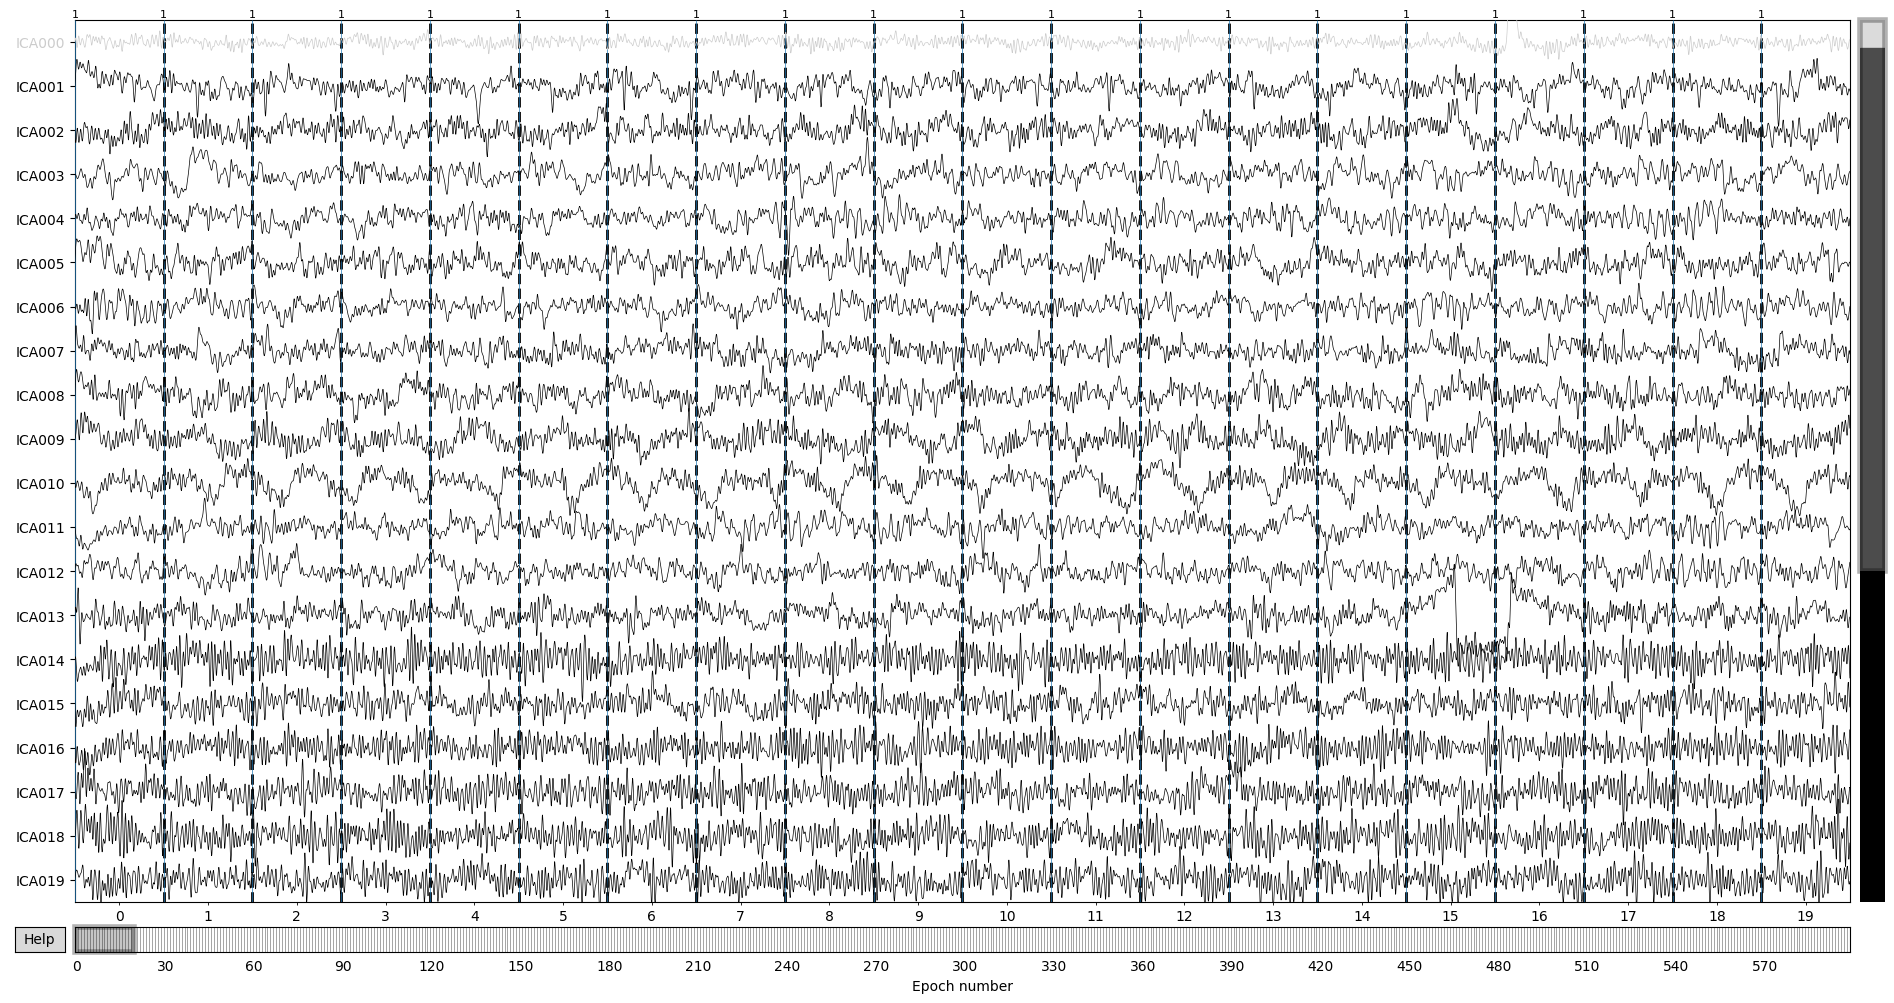

In [23]:
# select the components to exclude, click on their name to visualize sources
ica.plot_sources(epochs, show_scrollbars=True)

#### 2.4. Apply ICA

Note that the components selected above will be excluded in this step!

In [26]:
raw_rs_ica = ica.apply(raw_rs)

raw_rs_ica.info['ica_method'] = method
raw_rs_ica.info['ica_n_components'] = n_components
raw_rs_ica.info['ica_n_excluded'] = len(ica.exclude)
raw_rs_ica.info['reject'] = reject["eeg"]

Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


#### 2.5. Recover RS segments

In [27]:
# Recover RS segments
duration_rs_before, duration_rs_after = resting_events['end_time'] - resting_events['start_time']
raw_rs_ica_1 = raw_rs_ica.copy().crop(tmin=0.0, tmax=duration_rs_before, include_tmax=True)
raw_rs_ica_2 = raw_rs_ica.copy().crop(tmin=duration_rs_before+0.002, tmax=raw_rs_ica.times.max(), include_tmax=True)


In [30]:
del raw_rs_ica

#### 2.6. Save ICA cleaned raw data

In [29]:
# save clean epochs
period = resting_events['event'].values[0]
raw_clean_fname = f'{subject}_{condition}_{period}_ICA'
postfix = '-raw.fif.gz'
raw_rs_ica_1.save(os.path.join(interim_raw_path, f'{raw_clean_fname}{postfix}'), overwrite=False)

period = resting_events['event'].values[-1]
raw_clean_fname = f'{subject}_{condition}_{period}_ICA'
postfix = '-raw.fif.gz'
raw_rs_ica_2.save(os.path.join(interim_raw_path, f'{raw_clean_fname}{postfix}'), overwrite=False)

Writing D:\TMS_rewiring\preprocessed\L\raw_rs\24_L_rs_1_ICA-raw.fif.gz
Closing D:\TMS_rewiring\preprocessed\L\raw_rs\24_L_rs_1_ICA-raw.fif.gz
[done]
Writing D:\TMS_rewiring\preprocessed\L\raw_rs\24_L_rs_2_ICA-raw.fif.gz
Closing D:\TMS_rewiring\preprocessed\L\raw_rs\24_L_rs_2_ICA-raw.fif.gz
[done]


### 3. Create final epochs

#### 3.1. Resting before ASRT

In [32]:
# create fixed length epoch for preprocessing
EPOCH_LENGTH_IN_SECONDS = 2.0
OVERLAP = 0.5 * EPOCH_LENGTH_IN_SECONDS

events_rs_before = mne.make_fixed_length_events(raw_rs_ica_1,
                                  id=1,
                                  first_samp=True,
                                  duration=EPOCH_LENGTH_IN_SECONDS,
                                  overlap=OVERLAP)

epochs_rs_before = mne.Epochs(raw=raw_rs_ica_1,
                    events=events_rs_before,
                    picks='eeg',
                    event_id=1,
                    baseline=None,
                    tmin=0.,
                    tmax=EPOCH_LENGTH_IN_SECONDS - 0.002,
                    preload=True)

Not setting metadata
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Loading data for 299 events and 1000 original time points ...
0 bad epochs dropped


In [33]:
del raw_rs_ica_1

#### 3.2. Resting after ASRT

In [34]:
# create fixed length epoch for preprocessing
EPOCH_LENGTH_IN_SECONDS = 2.0
OVERLAP = 0.5 * EPOCH_LENGTH_IN_SECONDS

events_rs_after = mne.make_fixed_length_events(raw_rs_ica_2,
                                  id=1,
                                  first_samp=True,
                                  duration=EPOCH_LENGTH_IN_SECONDS,
                                  overlap=OVERLAP)

epochs_rs_after = mne.Epochs(raw=raw_rs_ica_2,
                    events=events_rs_after,
                    picks='eeg',
                    event_id=1,
                    baseline=None,
                    tmin=0.,
                    tmax=EPOCH_LENGTH_IN_SECONDS - 0.002,
                    preload=True)

Not setting metadata
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Loading data for 299 events and 1000 original time points ...
0 bad epochs dropped


In [35]:
del raw_rs_ica_2

### 4. Run Autoreject
#### 4.1. Resting before ASRT

In [36]:
# run autoreject on epochs
ar = autoreject.AutoReject(random_state=42, n_jobs=8)#(random_state=42, n_jobs=1, verbose='tqdm')
_, reject_log_rs_before = ar.fit(epochs_rs_before).transform(epochs_rs_before, return_log=True)

Running autoreject on ch_type=eeg








Estimated consensus=0.30 and n_interpolate=1



Dropped 166 epochs: 0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 29, 30, 34, 39, 40, 41, 44, 48, 49, 50, 51, 56, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 79, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 111, 112, 114, 116, 117, 118, 126, 127, 134, 135, 136, 137, 142, 143, 144, 145, 147, 152, 153, 154, 155, 156, 157, 160, 161, 162, 163, 164, 166, 169, 170, 171, 175, 176, 177, 178, 179, 180, 182, 186, 189, 190, 191, 194, 195, 196, 197, 198, 201, 202, 204, 205, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 223, 224, 225, 226, 235, 237, 249, 250, 263, 264, 266, 267, 270, 272, 273, 274, 275, 276, 278, 282, 283, 284, 286, 287, 288, 289, 290, 291, 292, 293, 295, 296


#### 4.2. Resting after ASRT

In [37]:
_, reject_log_rs_after = ar.fit(epochs_rs_after).transform(epochs_rs_after, return_log=True) n_interpolate could be 1

Running autoreject on ch_type=eeg








Estimated consensus=0.40 and n_interpolate=1



Dropped 10 epochs: 5, 12, 176, 178, 179, 190, 227, 230, 231, 244


### 5. Exclusion of bad epochs

#### 5.1. Drop bad segments - resting before ASRT

In [38]:
reject_df = pd.DataFrame(data=reject_log_rs_before.labels, columns=epochs.info['ch_names'])
# 0 : good data segment
# 1 : bad data segment not interpolated
# 2 : bad data segment interpolated
reject_df = reject_df.replace(2, 1)

# drop epochs where more than 20% of sensors were marked as bad
drop_list = reject_df.astype(bool).sum(axis=1) > 12

# merge this list with the originally marked bad epochs
bad_segments = np.logical_or(reject_log_rs_before.bad_epochs, np.array(drop_list))

In [39]:
epochs_rs_before_dropped = epochs_rs_before.copy().drop(indices=bad_segments, reason='AUTOREJECT', verbose=True)

Dropped 255 epochs: 0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 33, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 223, 224, 225, 226, 227, 231, 233, 234, 235, 237, 238, 239, 241, 242, 243, 244, 245, 246, 249, 250, 251, 253, 254, 2

In [ ]:
# Manual workflow

color_map = {0: None, 1: 'r', 2: (0.6, 0.6, 0.6, 1.0)}
epoch_colors = list()
for epoch_idx, label_epoch in enumerate(reject_log_rs_before.labels):
    if bad_segments[epoch_idx]:
        epoch_color = ['r'] * 64
        epoch_colors.append(epoch_color)
        continue
    epoch_color = list()
    for this_label in label_epoch:
        if not np.isnan(this_label):
            epoch_color.append(color_map[this_label])
        else:
            epoch_color.append(None)
    epoch_colors.append(epoch_color)

period = resting_events['event'].values[0]
fid = f'{subject}_{condition}_{period}'  

epochs_rs_before.plot(title=fid,
                n_channels=32,
                n_epochs=10,
                epoch_colors=epoch_colors)

#### 5.1.2. Manual rejection of epochs (optional)

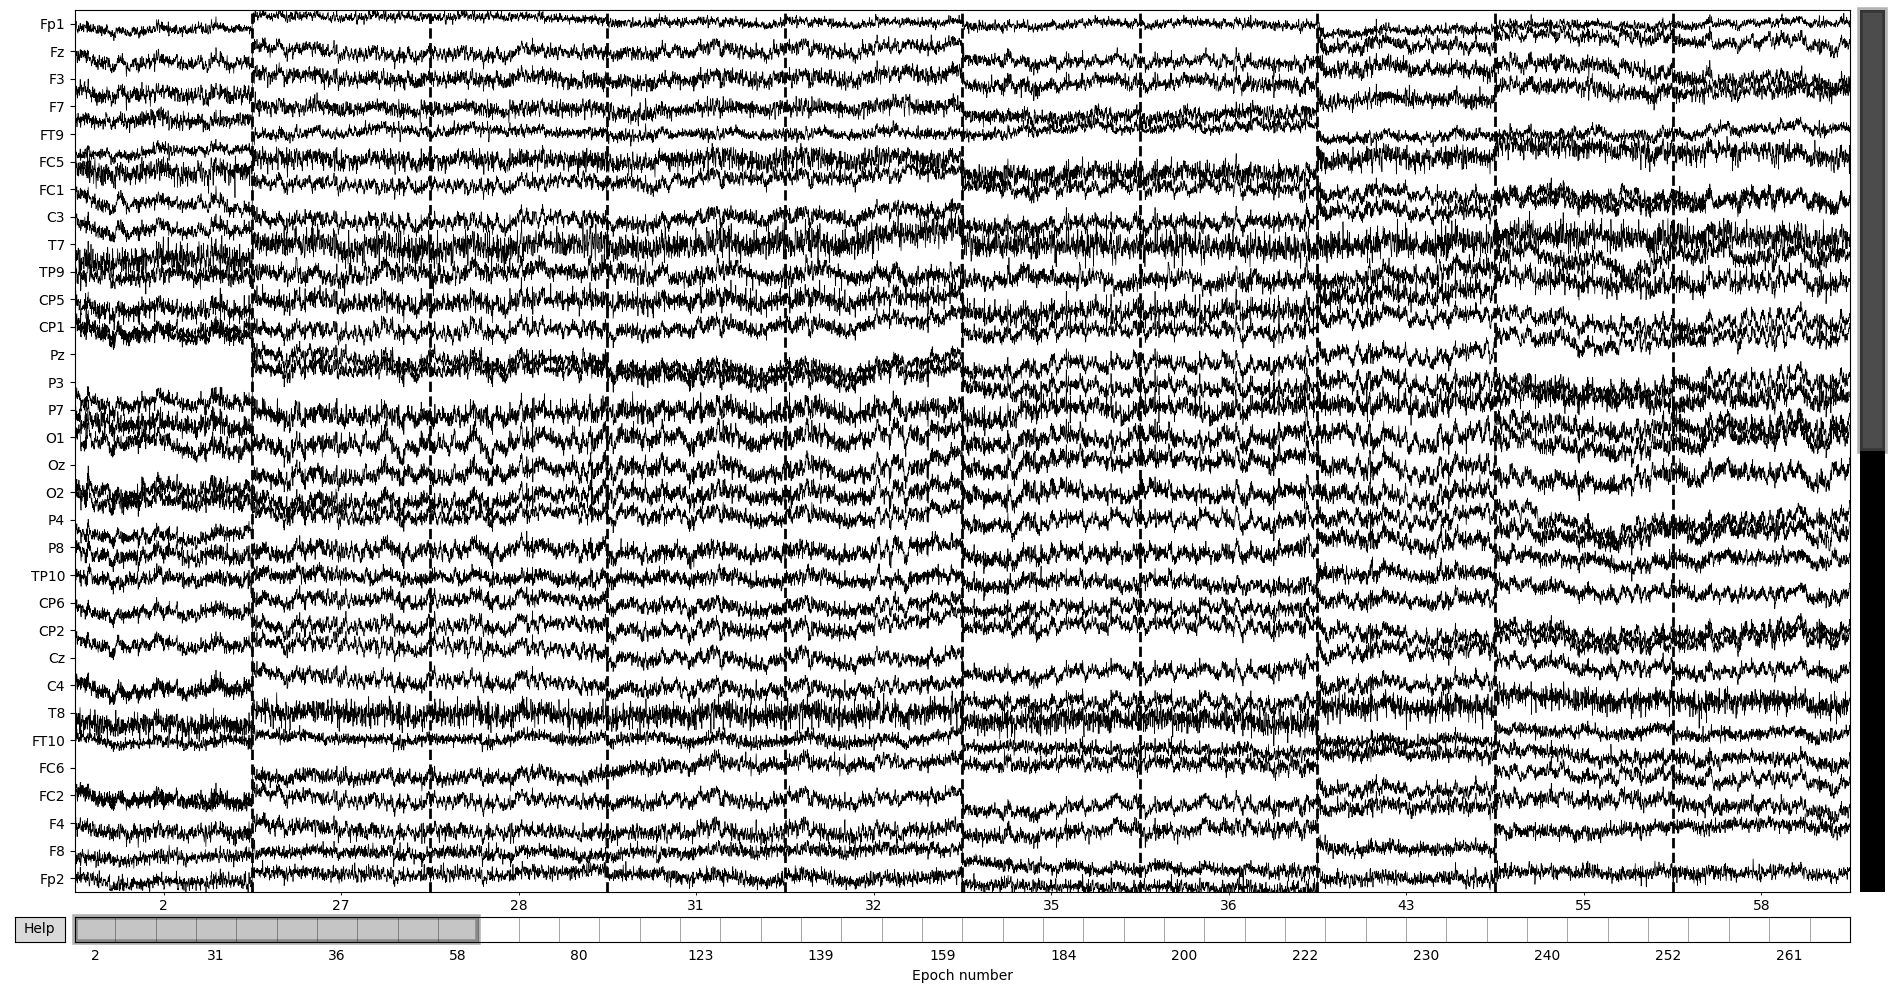

Dropped 0 epochs: 
Channels marked as bad: none


In [40]:
period = resting_events['event'].values[0]
fid = f'{subject}_{condition}_{period}'  

epochs_rs_before_dropped.plot(title=fid,
                n_channels=32,
                n_epochs=10)

##### 5.2. Resting after ASRT

In [41]:
reject_df = pd.DataFrame(data=reject_log_rs_after.labels, columns=epochs.info['ch_names'])
# 0 : good data segment
# 1 : bad data segment not interpolated
# 2 : bad data segment interpolated
reject_df = reject_df.replace(2, 1)

# drop epochs where more than 20% of sensors were marked as bad
drop_list = reject_df.astype(bool).sum(axis=1) > 12

# merge this list with the originally marked bad epochs
bad_segments = np.logical_or(reject_log_rs_after.bad_epochs, np.array(drop_list))

In [42]:
epochs_rs_after_dropped = epochs_rs_after.copy().drop(indices=bad_segments, reason='AUTOREJECT', verbose=True)

Dropped 73 epochs: 0, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 23, 26, 48, 49, 58, 59, 60, 61, 67, 68, 85, 86, 87, 88, 89, 90, 94, 97, 99, 100, 101, 102, 105, 129, 130, 138, 143, 144, 145, 152, 162, 163, 164, 166, 167, 168, 171, 175, 176, 177, 178, 179, 180, 190, 191, 222, 226, 227, 228, 230, 231, 244, 245, 262, 286, 287


In [ ]:
epoch_colors = list()
for epoch_idx, label_epoch in enumerate(reject_log_rs_after.labels):
    if bad_segments[epoch_idx]:
        epoch_color = ['r'] * 64
        epoch_colors.append(epoch_color)
        continue
    epoch_color = list()
    for this_label in label_epoch:
        if not np.isnan(this_label):
            epoch_color.append(color_map[this_label])
        else:
            epoch_color.append(None)
    epoch_colors.append(epoch_color)

epochs_rs_after.plot(title=fid,
                n_channels=32,
                n_epochs=5,
                epoch_colors=epoch_colors)

In [ ]:
#### 5.2.2. Manual rejection of epochs (optional)

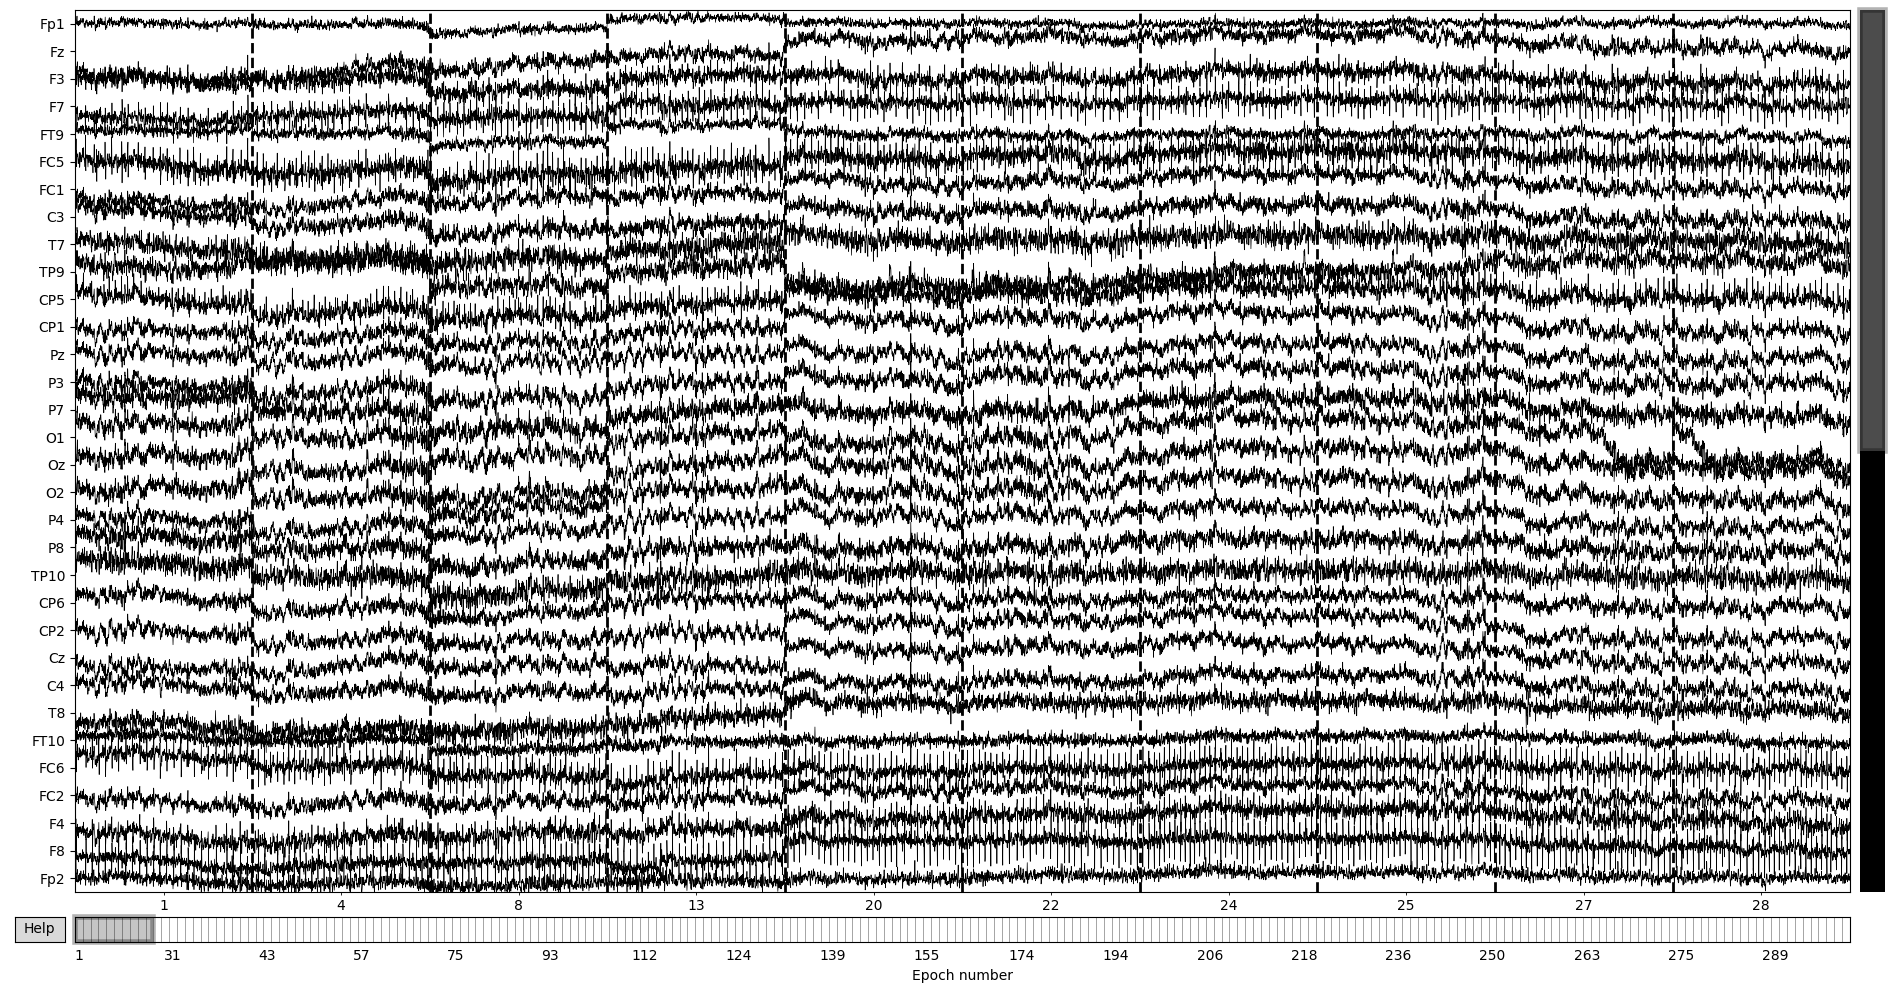

Dropped 0 epochs: 
Channels marked as bad: none


In [43]:
period = resting_events['event'].values[-1]
fid = f'{subject}_{condition}_{period}'  

epochs_rs_after_dropped.plot(title=fid,
                n_channels=32,
                n_epochs=10)

In [44]:
from datetime import timezone
# Add information about how many epochs were dropped
epochs_rs_before_dropped.info['dropped'] = [drop for drop in epochs_rs_before_dropped.drop_log if drop]
epochs_rs_before_dropped.info['n_dropped'] = len([drop for drop in epochs_rs_before_dropped.drop_log if drop])
epochs_rs_before_dropped.info['file_create_date'] = datetime.now(timezone.utc)

# Save clean epochs
period = resting_events['event'].values[0]
fid = f'{subject}_{condition}_{period}'

epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'

epochs_rs_before_dropped.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [46]:
# Add information about how many epochs were dropped
epochs_rs_after_dropped.info['dropped'] = [drop for drop in epochs_rs_after_dropped.drop_log if drop]
epochs_rs_after_dropped.info['n_dropped'] = len([drop for drop in epochs_rs_after_dropped.drop_log if drop])
epochs_rs_after_dropped.info['file_create_date'] = datetime.now(timezone.utc)

# Save clean epochs
period = resting_events['event'].values[-1]
fid = f'{subject}_{condition}_{period}'

epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'

epochs_rs_after_dropped.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [48]:
del epochs_rs_before, epochs_rs_after

### 6. Interpolate bad channels

In [50]:
manual_bad_channels = epochs_rs_before_dropped.info['bads']
epochs_rs_before_dropped.interpolate_bads(reset_bads=True)

ransac = autoreject.Ransac(verbose='progressbar', n_jobs=1)
epochs_rs_before_ransac = ransac.fit_transform(epochs_rs_before_dropped)

epochs_rs_before_ransac.info['rancac_bad_channels'] = ransac.bad_chs_
epochs_rs_before_ransac.info['manual_bad_channels'] = manual_bad_channels

<ipython-input-50-61bca38cfbb3>:2: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs_rs_before_dropped.interpolate_bads(reset_bads=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Interpolating bad channels
    Automatic origin fit: head of radius 85.0 mm
Computing interpolation matrix from 48 sensor positions
Interpolating 16 sensors


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished


In [51]:
# set average reference
epochs_rs_before_ransac.set_eeg_reference()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


<Epochs |  44 events (all good), 0 - 1.998 sec, baseline off, ~21.6 MB, data loaded,
 '1': 44>

In [52]:
manual_bad_channels = epochs_rs_after_dropped.info['bads']
epochs_rs_after_dropped.interpolate_bads(reset_bads=True)

ransac = autoreject.Ransac(verbose='progressbar', n_jobs=1)
epochs_rs_after_ransac = ransac.fit_transform(epochs_rs_after_dropped)

epochs_rs_after_ransac.info['rancac_bad_channels'] = ransac.bad_chs_
epochs_rs_after_ransac.info['manual_bad_channels'] = manual_bad_channels

<ipython-input-52-0d513530fc0f>:2: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs_rs_after_dropped.interpolate_bads(reset_bads=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Interpolating bad channels
    Automatic origin fit: head of radius 85.0 mm
Computing interpolation matrix from 49 sensor positions
Interpolating 15 sensors


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.6s finished


In [53]:
# set average reference
epochs_rs_after_ransac.set_eeg_reference()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


<Epochs |  226 events (all good), 0 - 1.998 sec, baseline off, ~110.4 MB, data loaded,
 '1': 226>

In [55]:
del epochs_rs_before_dropped, epochs_rs_after_dropped

### 7. Save clean data

In [56]:
# Add information about how many epochs were dropped
epochs_rs_before_ransac.info['dropped'] = [drop for drop in epochs_rs_before_ransac.drop_log if drop]
epochs_rs_before_ransac.info['n_dropped'] = len([drop for drop in epochs_rs_before_ransac.drop_log if drop])

# Save clean epochs
period = resting_events['event'].values[0]
fid = f'{subject}_{condition}_{period}'

epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'

epochs_rs_before_ransac.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

Overwriting existing file.


In [57]:
# Add information about how many epochs were dropped
epochs_rs_after_ransac.info['dropped'] = [drop for drop in epochs_rs_after_ransac.drop_log if drop]
epochs_rs_after_ransac.info['n_dropped'] = len([drop for drop in epochs_rs_after_ransac.drop_log if drop])

# Save clean epochs
period = resting_events['event'].values[-1]
fid = f'{subject}_{condition}_{period}'

epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'

epochs_rs_after_ransac.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

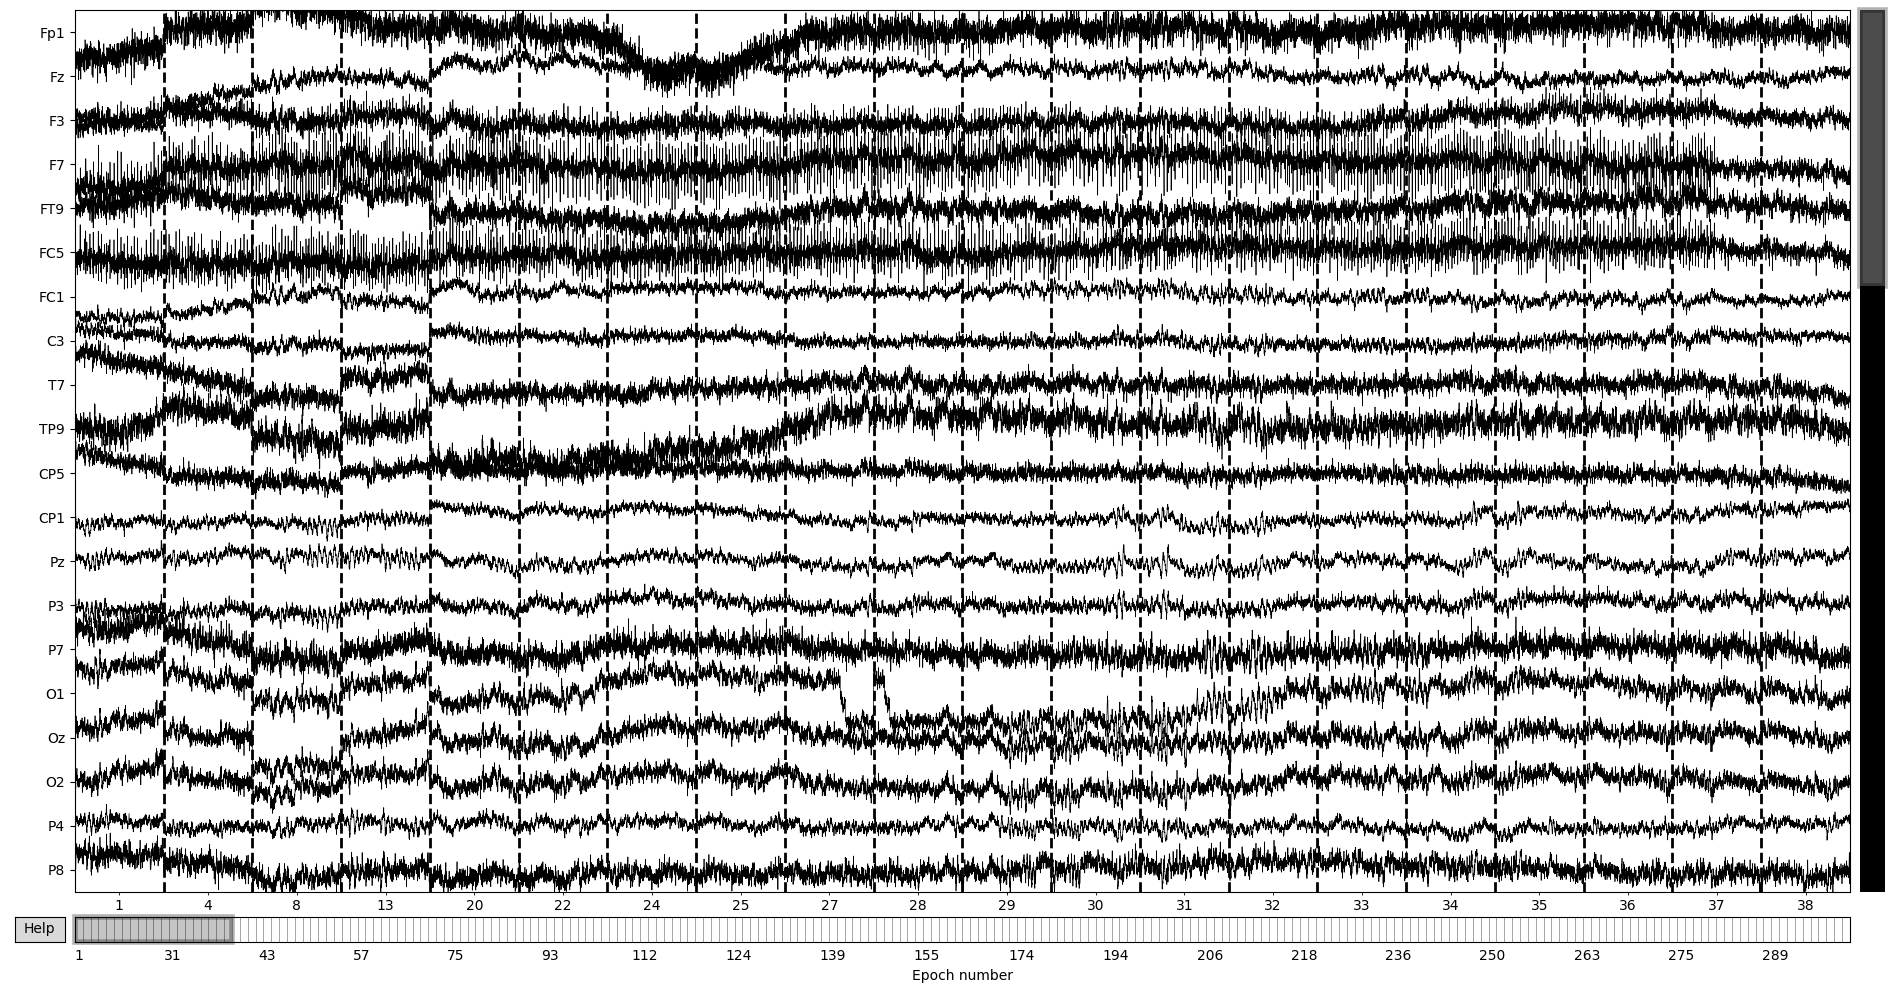

Dropped 0 epochs: 
Channels marked as bad: none


In [58]:
epochs_rs_after_ransac.plot()

## II. ASRT

In [ ]:
# Create path to interim epoch files
interim_epochs_path = os.path.join(interim_path, condition, 'epochs_asrt')
if not os.path.exists(interim_epochs_path):
    os.makedirs(interim_epochs_path)

# Create path to interim raw files
interim_raw_path = os.path.join(interim_path, condition, 'raw_asrt')
if not os.path.exists(interim_raw_path):
    os.makedirs(interim_raw_path)

In [ ]:
block_events.head(5)

In [ ]:
raws = []
for idx, event in block_events.iterrows():
    raws.append(raw_filtered.copy().crop(tmin=event['start_time'], tmax=event['end_time'], include_tmax=True))
    
raw_filtered_asrt = mne.concatenate_raws(raws)

In [ ]:
raws = []
for idx, event in block_events.iterrows():
    raws.append(raw_filtered_ica.copy().crop(tmin=event['start_time'], tmax=event['end_time'], include_tmax=True))
    
raw_filtered_asrt_ica = mne.concatenate_raws(raws)

In [ ]:
# interactively scroll through data
# interactively scroll through data
#period = '_and_'.join(resting_events['event'].values)
fid = f'{subject}_{condition}_asrt_{num_day}'
raw_filtered_asrt.plot(title=fid,
                   n_channels=32,
                   remove_dc=True)

In [ ]:
# create fixed length epoch for preprocessing
EPOCH_LENGTH_IN_SECONDS = 2.0
#OVERLAP = 0.5 * EPOCH_LENGTH_IN_SECONDS

events = mne.make_fixed_length_events(raw_filtered_asrt_ica,
                                  id=1,
                                  first_samp=True,
                                  duration=EPOCH_LENGTH_IN_SECONDS,
                                  overlap=0.0)

epochs = mne.Epochs(raw=raw_filtered_asrt_ica,
                    events=events,
                    picks='eeg',
                    event_id=1,
                    baseline=None,
                    tmin=0.,
                    tmax=EPOCH_LENGTH_IN_SECONDS - 0.002,
                    preload=True)

In [ ]:
# find global rejection threshold for ICA
reject = autoreject.get_rejection_threshold(epochs)

In [ ]:
100e-6 < reject['eeg']

In [ ]:
reject

In [ ]:
reject

In [ ]:
n_components = 32
method = 'infomax'

ica = mne.preprocessing.ICA(n_components=n_components, random_state=42, method=method)
ica.fit(epochs, reject=reject, tstep=EPOCH_LENGTH_IN_SECONDS)

In [ ]:
ica.plot_components()

In [ ]:
# select the components to exclude, click on their name to visualize sources
ica.plot_sources(epochs, show_scrollbars=True)

In [ ]:
epochs_ica = ica.apply(epochs)
raw_filtered_asrt_ica = ica.apply(raw_filtered_asrt)

raw_filtered_asrt_ica.info['ica_method'] = method
raw_filtered_asrt_ica.info['ica_n_components'] = n_components
raw_filtered_asrt_ica.info['ica_n_excluded'] = len(ica.exclude)

In [ ]:
# # interactively scroll through data
raw_filtered_asrt_ica.plot(title=fid,
                   n_channels=32,
                   remove_dc=True)

In [ ]:
# save clean epochs

raw_clean_fname = f'{fid}_ICA'
postfix = '-raw.fif.gz'
raw_filtered_asrt_ica.save(os.path.join(interim_raw_path, f'{raw_clean_fname}{postfix}'), overwrite=False)

In [ ]:
# start_times = [events[idx][0] / raw.info['sfreq'] for idx in range(len(events)-1) if bad_segments[idx]]

# raw_filtered_rs_ica.annotations.append(onset=start_times,
#                                  duration=[(events[1][0] - events[0][0]) / raw.info['sfreq']] * len(start_times),
#                                  description='BAD_autoreject',)


In [ ]:
# # interactively scroll through data
raw_filtered_asrt_ica.plot(title=fid,
                   n_channels=32,
                   remove_dc=True,
                   show_options=True,
                   show_scalebars=True)

In [ ]:
# run autoreject on epochs
ar = autoreject.AutoReject(random_state=42, n_jobs=8)#(random_state=42, n_jobs=1, verbose='tqdm')
_, reject_log_asrt = ar.fit(epochs).transform(epochs, return_log=True)

In [ ]:
reject_df = pd.DataFrame(data=reject_log_asrt.labels, columns=epochs.info['ch_names'])
# 0 : good data segment
# 1 : bad data segment not interpolated
# 2 : bad data segment interpolated
reject_df = reject_df.replace(2, 1)

# drop epochs where more than 20% of sensors were marked as bad
drop_list = reject_df.astype(bool).sum(axis=1) > 12

# merge this list with the originally marked bad epochs
bad_segments = np.logical_or(reject_log_asrt.bad_epochs, np.array(drop_list))

In [ ]:
reject_df.shape

In [ ]:
start_times = [events[idx][0] / raw.info['sfreq'] for idx in range(epochs.events.shape[0]) if bad_segments[idx]]

raw_filtered_asrt_ica.annotations.append(onset=start_times,
                                  duration=[(events[1][0] - events[0][0]) / raw.info['sfreq']] * len(start_times),
                                 description='BAD_autoreject',)


In [ ]:
# save clean epochs
raw_clean_fname = f'{fid}_ICA'
postfix = '-raw.fif.gz'
raw_filtered_asrt_ica.save(os.path.join(interim_raw_path, f'{raw_clean_fname}{postfix}'), overwrite=True)

In [ ]:
# create fixed length epoch for preprocessing
EPOCH_LENGTH_IN_SECONDS = 2.0
OVERLAP = 0.5 * EPOCH_LENGTH_IN_SECONDS

events_asrt = mne.make_fixed_length_events(raw_filtered_asrt_ica,
                                  id=1,
                                  first_samp=True,
                                  duration=EPOCH_LENGTH_IN_SECONDS,
                                  overlap=OVERLAP)

epochs_asrt = mne.Epochs(raw=raw_filtered_asrt_ica.copy().filter(1,30),
                    events=events_asrt,
                    picks='eeg',
                    event_id=1,
                    baseline=None,
                    reject_by_annotation=True,
                    tmin=0.,
                    tmax=EPOCH_LENGTH_IN_SECONDS - 0.002,
                    preload=True)


new_events = mne.merge_events(events_from_annot, event_list, new_id=1, replace_events=False)
epochs_stim = mne.Epochs(raw=raw_filtered_asrt_ica,
                    events=new_events,
                    event_id=1,
                    picks='eeg',
                    reject_by_annotation=True,
                    baseline=None,
                    tmin=0.,
                    tmax=2,
                    preload=False)

In [ ]:
epochs_stim

In [ ]:
new_events = mne.merge_events(events_from_annot, [10,11,12,13,14,15,16], new_id=1, replace_events=False)

In [ ]:
datetime.utcnow()

In [ ]:
import datetime


# Add information about how many epochs were dropped
epochs_asrt.info['dropped'] = [drop for drop in epochs_asrt.drop_log if drop]
epochs_asrt.info['n_dropped'] = len([drop for drop in epochs_asrt.drop_log if drop])
epochs_asrt.info['file_create_date'] = datetime.datetime.now(datetime.timezone.utc)

# Save clean epochs
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'

epochs_asrt.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
epochs_asrt.plot(n_epochs=5)

In [ ]:
manual_bad_channels = epochs_asrt.info['bads']
epochs_asrt.interpolate_bads(reset_bads=True)

ransac = autoreject.Ransac(verbose='progressbar', n_jobs=1)
epochs_asrt_ransac = ransac.fit_transform(epochs_asrt)

epochs_asrt_ransac.info['rancac_bad_channels'] = ransac.bad_chs_
epochs_asrt_ransac.info['manual_bad_channels'] = manual_bad_channels

In [ ]:
epochs_asrt_ransac.set_eeg_reference()

In [ ]:
manual_bad_channels = epochs_asrt.info['bads']
epochs_asrt.interpolate_bads(reset_bads=True)

In [ ]:
epochs_asrt_ransac.info['manual_bad_channels'] = manual_bad_channels
# # save clean epochs
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
print(epochs_clean_fname)
postfix = '-epo.fif.gz'
epochs_asrt_ransac.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
epochs_asrt_ransac.info['rancac_bad_channels']

In [ ]:
epochs_asrt_ransac.plot(n_epochs=10,
                       n_channels=32)

In [ ]:
# # Add information about how many epochs were dropped
# epochs_clean.info['dropped'] = [drop for drop in epochs_clean.drop_log if drop]
# epochs_clean.info['n_dropped'] = len([drop for drop in epochs_clean.drop_log if drop])
# epochs_clean.info['file_create_date'] = datetime.utcnow()

# # Save clean epochs
# epochs_clean_fname = f'{fid}_ICA_autoreject'
# postfix = '-epo.fif.gz'

# epochs_clean.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'))

In [ ]:
#epochs_ar_dropped = epochs_ar.copy().drop(indices=drop_list, reason='AUTOREJECT', verbose=True)